# How to Segment Buildings on Drone Imagery with Fast.ai & Cloud-Native GeoData Tools

## An Interactive Intro to Geospatial Deep Learning on Google Colab 




# Train u-net segmentation model with fastai & pytorch

As our deep learning framework and library of tools, we'll use the excellent [fastai](https://github.com/fastai/fastai) library built on top of [PyTorch](https://pytorch.org/). 

For more info:
- about Fast.ai, the organization: https://www.fast.ai/about/
- direct links to the free MOOC series: 
  - Part 1 ("Practical Deep Learning for Coders"): https://course.fast.ai/index.html
  - Part 2 ("Deep Learning from the Foundations"): https://course.fast.ai/part2

## Download and install fastai

Let's download, install, and set up fastai v1 (currently at 1.0.55). And if we're not already on it, let's reset Colab to a GPU runtime (this removes locally stored files since it switches to a new environment so you will have to re-download and untar the training dataset created in above steps):

**SWITCH TO GPU RUNTIME: Menu > Runtime > Change runtime type > Hardware Accelerator = GPU**

Colab's free GPUs range from a Tesla K80, T4, or T8 depending on their availability. See the `===Hardware===` section of `show_install()` for what GPU type and how much GPU memory  is available which will affect the batch size and training time.

For all of these GPUs and mem sizes, a batch size of `bs=16` at `size=256` should train at <2 mins/epoch without encountering out-of-memory issues but if it does comes up, lower the bs to 8.


In [2]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0     57      0  0:00:05  0:00:05 --:--:--    79
Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.callbacks import *

In [4]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.59
fastprogress  : 0.1.22
torch         : 1.3.1
nvidia driver : 418.67
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Fri Dec 27 15:54:23 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+-------------------

## Set up data

Now we'll set up our training dataset of tile images and masks created above to load correctly into fastai for training and validation. 

The code in this step tracks closely with that of fastai course's lesson3-camvid so please refer to that [lesson video](https://course.fast.ai/videos/?lesson=3) and [notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb) for more detailed and excellent explanation by Jeremy Howard about the code and fastai's [Data Block API](https://docs.fast.ai/data_block.html).

The main departures from the camvid lesson notebook is the use of filename string parsing to determine which image and mask files comprise the validation data.

And we'll subclass `SegmentationLabelList` to alter the behavior of `open_mask` and `PIL.Image` underlying it in order to open the 3-channel target masks as RGB images `(convert_mode='RGB')` instead of default greyscale 1-channel images `(convert_mode='L')`.

We'll also visually confirm that the image files and channels of the respective target mask file are loaded and paired correctly with a display function `show_3ch`.

In [5]:
# to mount and transfer to GDrive: uncomment and run this and the next cell, follow instructions to auhorize access to your GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_path = "drive/My Drive/datasets/RIO/"
src_raster_dir = base_path + "3band/"
src_vector_dir = base_path + "vectordata/geojson/"
dst_dir = base_path + "masks2/"

In [7]:
path = Path(base_path)
path.ls()

[PosixPath('drive/My Drive/datasets/RIO/3band'),
 PosixPath('drive/My Drive/datasets/RIO/vectordata'),
 PosixPath('drive/My Drive/datasets/RIO/masks'),
 PosixPath('drive/My Drive/datasets/RIO/masks_2')]

In [0]:
path_lbl = path/'masks_2'
path_img = path/'3band'

In [9]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
print(len(fnames), len(lbl_names))
fnames[:3], lbl_names[:3]

6940 6940


([PosixPath('drive/My Drive/datasets/RIO/3band/3band_AOI_1_RIO_img4856.tif'),
  PosixPath('drive/My Drive/datasets/RIO/3band/3band_AOI_1_RIO_img1894.tif'),
  PosixPath('drive/My Drive/datasets/RIO/3band/3band_AOI_1_RIO_img3763.tif')],
 [PosixPath('drive/My Drive/datasets/RIO/masks_2/3band_AOI_1_RIO_img5941.tif'),
  PosixPath('drive/My Drive/datasets/RIO/masks_2/3band_AOI_1_RIO_img5942.tif'),
  PosixPath('drive/My Drive/datasets/RIO/masks_2/3band_AOI_1_RIO_img5943.tif')])

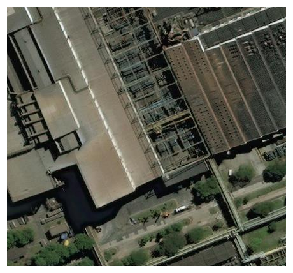

In [10]:
random_img_idx = 20
img_f = fnames[random_img_idx]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [12]:
print(fnames[random_img_idx])
print(get_y_fn(fnames[random_img_idx]))

drive/My Drive/datasets/RIO/3band/3band_AOI_1_RIO_img288.tif
drive/My Drive/datasets/RIO/masks_2/3band_AOI_1_RIO_img288.tif


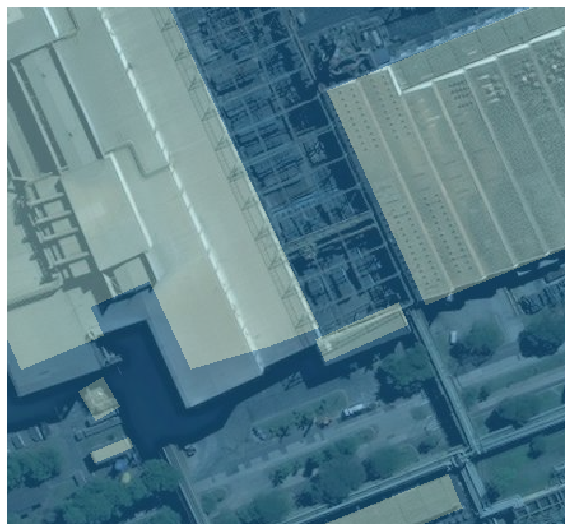

In [13]:
# test that masks are opening correctly with open_mask() settings
img_f = fnames[random_img_idx]
img = open_image(img_f)
mask = open_mask(get_y_fn(fnames[random_img_idx]))

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [14]:
mask = open_mask(get_y_fn(img_f))
np.unique(mask.px)

array([0., 1.], dtype=float32)

(array([95085., 82743.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

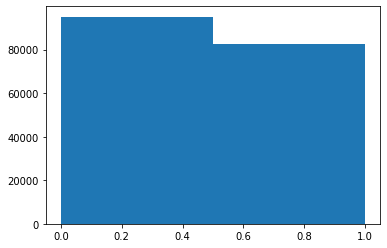

In [15]:
plt.hist(mask.data.view(-1), bins=2)

In [16]:
src_size = np.array(mask.shape[1:])
size = src_size
src_size, img.shape, size

(array([406, 438]), torch.Size([3, 406, 438]), array([406, 438]))

## Set up data

In [17]:
from fastai.utils.mem import *
free = gpu_mem_get_free_no_cache()
print(free)
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

16270
using bs=8, have 16270MB of GPU RAM free


In [18]:
# the classes corresponding to each channel
codes = np.array(['Void', 'Building'])
print(codes)
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct(0.5, seed = 1)
       .label_from_func(get_y_fn, classes=codes))
src

['Void' 'Building']


LabelLists;

Train: LabelList (3470 items)
x: SegmentationItemList
Image (3, 406, 439),Image (3, 406, 439),Image (3, 406, 439),Image (3, 406, 439),Image (3, 407, 439)
y: SegmentationLabelList
ImageSegment (1, 406, 439),ImageSegment (1, 406, 439),ImageSegment (1, 406, 439),ImageSegment (1, 406, 439),ImageSegment (1, 407, 439)
Path: drive/My Drive/datasets/RIO/3band;

Valid: LabelList (3470 items)
x: SegmentationItemList
Image (3, 406, 438),Image (3, 406, 439),Image (3, 406, 439),Image (3, 406, 438),Image (3, 406, 438)
y: SegmentationLabelList
ImageSegment (1, 406, 438),ImageSegment (1, 406, 439),ImageSegment (1, 406, 439),ImageSegment (1, 406, 438),ImageSegment (1, 406, 438)
Path: drive/My Drive/datasets/RIO/3band;

Test: None

In [0]:
# define image transforms for data augmentation and create databunch. More about image tfms and data aug at https://docs.fast.ai/vision.transform.html 
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)

data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
# visually inspect data-augmented training images
# TODO: show_batch doesn't display RGB mask correctly, setting alpha=0 to turn off for now
# quite slow!
#data.show_batch(4,figsize=(10,10), alpha=0.)

## Define custom losses and metrics to handle 3-channel targets

Here we implement some new loss functions like Dice Loss and Focal Loss which have been shown to perform well in image segmentation tasks. Then we'll create a `MultiChComboLoss` class to combine multiple loss functions and  calculate them across the 3 channels with adjustable weighting.

The approach of combining a Dice or Jaccard loss to consider image-wide context with individual pixel-focused Binary Cross Entropy or Focal loss with adjustable weighing of the 3 target mask channels has been shown to consistently outperform single loss functions. This is well-documented by Nick Weir's deep dive into the recent [SpaceNet 4 Off-Nadir Building Detection](https://spacenetchallenge.github.io/datasets/spacenet-OffNadir-summary.html) top results: 

https://medium.com/the-downlinq/a-deep-dive-into-the-spacenet-4-winning-algorithms-8d611a5dfe25

Finally, we adapt our model evaluation metrics (accuracy and dice score) to calculate a mean score for all channels or by a specified individual channel.

In [0]:
import pdb

def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1) == target).float().mean()

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        ch_loss=0
        for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
            ch_loss+=loss_wt*loss_func(output[:,1,None], target[:,0,None])
        loss+=1*(ch_loss)
        return loss/sum(self.ch_wts)

# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels
def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,0,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,0,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)



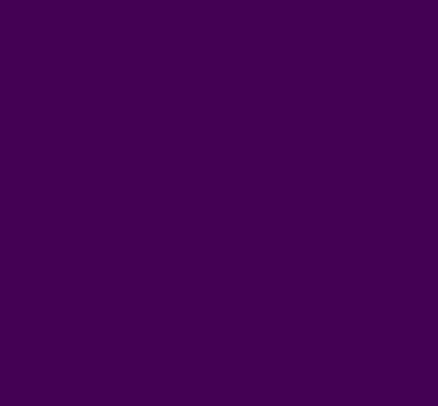

In [22]:
data.valid_ds[1][1]

In [23]:
target = data.valid_ds[1][1].px.numpy()
target = torch.tensor([target, target])
input = torch.tensor(np.zeros([2,2,406,438]))
print(input.shape)
print(target.shape)

assert(dice_multich(input, target, one_ch=0) == torch.tensor(1.))


torch.Size([2, 2, 406, 438])
torch.Size([2, 1, 406, 438])


## Set up model

We'll set up fastai's Dynamic Unet model with an ImageNet-pretrained resnet34 encoder. This architecture, inspired by the original U-net, uses by default many advanced deep learning techniques such as:

- One cycle learning schedule: https://sgugger.github.io/the-1cycle-policy.html
- AdamW optimizer: https://www.fast.ai/2018/07/02/adam-weight-decay/
- Pixel shuffle upsampling with ICNR initiation from super resolution research: https://medium.com/@hirotoschwert/introduction-to-deep-super-resolution-c052d84ce8cf
- Optionally set leaky ReLU, blur, self attention: https://docs.fast.ai/vision.models.unet.html#DynamicUnet

We'll define our `MultiChComboLoss` function as a balanced combination of Focal Loss and Dice Loss and set our accuracy and dice metrics. 

Also note that our metrics displayed during training shows channel-0 (building footprint channel only) accuracy and dice metrics in the right-most 2 columns while the first two accuracy and dice metrics (left-hand columns) show the mean of the respective metric across all 3 channels.

In [0]:
# set up metrics to show mean metrics for all channels as well as the building-only metrics (channel 0)
from datetime import datetime
def fmt_now():
    return datetime.today().strftime('%Y%m%d-%H%M%S')

metrics = acc_camvid
callbacks = [
    # update a graph of learner stats and metrics after each epoch
    ShowGraph,

    # save model at every metric improvement
    partial(SaveModelCallback, every='improvement', monitor='acc_camvid', name=f"{fmt_now()}_unet_resnet34_stage1_best"),
    
    # stop training if metric no longer improve
    partial(EarlyStoppingCallback, monitor='acc_camvid', min_delta=0.01, patience=2),
]

#learn.destroy()
#learn = unet_learner(data, models.resnet34, model_dir='../../models',
#                     metrics=metrics,
#                     callback_fns=callbacks)


In [25]:
acc_ch1 = partial(acc_thresh_multich, one_ch=1)
dice_ch1 = partial(dice_multich, one_ch=1)
metrics = [acc_ch1, dice_ch1]


learn = unet_learner(data, models.resnet34, model_dir='../../models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1])
                    )


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 53.2MB/s]


In [26]:
learn.metrics

[functools.partial(<function acc_thresh_multich at 0x7fc1bd73dbf8>, one_ch=1),
 functools.partial(<function dice_multich at 0x7fc1ba81f510>, one_ch=1)]

In [27]:
learn.loss_func

MultiChComboLoss()

In [0]:
#learn.summary()

## Train model, inspect results, unfreeze & train more, export for inference

First, we'll fine-tune our Unet on the decoder part only (leaving the weights for the ImageNet-pretrained resnet34 encoder frozen) for some epochs. Then we'll unfreeze all the trainable weights/layers of our model and train for some more epochs.

We'll track the `valid_loss`, `acc_...`, and `dice_..`. metrics per epoch as training progresses to make sure they continue to improve and we're not overfitting. And we set a `SaveModelCallback` which will track the channel-0 dice score, save a model checkpoint each time there's an improvement, and reload the highest performing model checkpoint file at the end of training.

We'll also inspect our model's results by setting `learn.model.eval()`, generating some batches of predictions on the validation set, calculating and reshaping the image-wise loss values, and sorting by highest loss first to see the worst performing results (as measured by the loss which may differ in surprising ways from visually gauging results). 

**Pro-tip:** display and view your results every chance you get! You'll pick up on all kinds of interesting clues about your model's behavior and how to make it better.

Finally, we'll export our trained Unet segmentation model for inference purposes as a `.pkl` file. Learn more about exporting fastai models for inference in this tutorial: https://docs.fast.ai/tutorial.inference.html

In [0]:
#learn.lr_find()

In [0]:
#learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-5
learn.fit_one_cycle(5, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='znz001trn-focaldice-stage1-best')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,time
0,0.341244,0.312172,0.910995,0.581940,40:55
1,0.295625,0.264392,0.932443,0.638725,05:34
2,0.277940,0.283960,0.911934,0.629535,05:35
3,0.268054,0.248346,0.934922,0.665219,05:33
4,0.259633,0.249260,0.933312,0.665111,05:34


Better model found at epoch 0 with dice_multich value: 0.5819395780563354.
Better model found at epoch 1 with dice_multich value: 0.6387246251106262.
Better model found at epoch 3 with dice_multich value: 0.6652185916900635.


In [0]:
lr = 1e-5
learn.fit_one_cycle(5, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='znz001trn-focaldice-stage1-best_2pass')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,time
0,0.265384,0.260949,0.924044,0.653070,05:32
1,0.258369,0.239274,0.939432,0.675652,05:33
2,0.251203,0.236113,0.938100,0.682458,05:34
3,0.248981,0.233096,0.940184,0.686517,05:33
4,0.258457,0.233665,0.938770,0.686625,05:33


Better model found at epoch 0 with dice_multich value: 0.6530700922012329.
Better model found at epoch 1 with dice_multich value: 0.6756519079208374.
Better model found at epoch 2 with dice_multich value: 0.6824581623077393.
Better model found at epoch 3 with dice_multich value: 0.6865172982215881.
Better model found at epoch 4 with dice_multich value: 0.6866247057914734.


In [0]:
lr = 1e-5
learn.fit_one_cycle(5, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='znz001trn-focaldice-stage1-best_3pass')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,time
0,0.251525,0.238680,0.934907,0.682070,05:32
1,0.244161,0.229972,0.942343,0.688767,05:34
2,0.242170,0.228944,0.940766,0.694903,05:34
3,0.237381,0.230368,0.938373,0.693016,05:32
4,0.237400,0.226435,0.941020,0.696247,05:32


Better model found at epoch 0 with dice_multich value: 0.6820703148841858.
Better model found at epoch 1 with dice_multich value: 0.6887670755386353.
Better model found at epoch 2 with dice_multich value: 0.6949030160903931.
Better model found at epoch 4 with dice_multich value: 0.6962469220161438.


In [0]:
lr = 1e-5
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='znz001trn-focaldice-stage1-best_3pass')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,time
0,0.229255,0.217164,0.941863,0.711962,05:35
1,0.219286,0.212760,0.945026,0.716006,05:34
2,0.231060,0.216030,0.943523,0.713399,05:35
3,0.219497,0.231204,0.934916,0.698059,05:33
4,0.226449,0.218619,0.941719,0.709394,05:32
5,0.221380,0.216587,0.946190,0.709006,05:32
6,0.222247,0.212167,0.945420,0.718156,05:32
7,0.219730,0.215973,0.941865,0.714226,05:32
8,0.222470,0.211499,0.945376,0.717871,05:32
9,0.213830,0.211156,0.944743,0.718821,05:32


Better model found at epoch 0 with dice_multich value: 0.7119624614715576.
Better model found at epoch 1 with dice_multich value: 0.7160060405731201.
Better model found at epoch 6 with dice_multich value: 0.7181562781333923.
Better model found at epoch 9 with dice_multich value: 0.7188212871551514.


In [0]:
learn.save('/content/drive/My Drive/models/rio0001trn-focaldice-freeze')
learn.export('/content/drive/My Drive/models/rio0001trn-focaldice-freeze.pkl')
!ls "/content/drive/My Drive/models/"

rio0001trn-focaldice-freeze.pkl      rio0001trn-focaldice-freeze.pth
rio0001trn-focaldice-freeze.pkl.pth


In [0]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=3,with_loss=True)
losses.shape

torch.Size([24, 1, 406, 438])

In [0]:
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)
losses_reshaped.shape

torch.Size([24])

In [0]:
learn.load('/content/drive/My Drive/models/rio0001trn-focaldice-freeze')

In [0]:
learn.model.train()
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-05
Min loss divided by 10: 9.12E-08


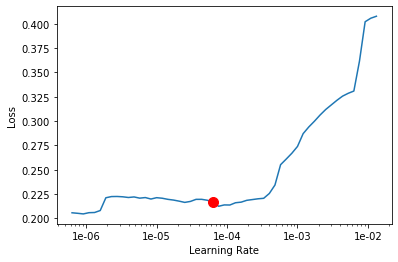

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(20, max_lr=slice(8e-6,8e-5), 
                    callbacks=[
                        SaveModelCallback(learn,
                                           monitor='dice_multich',
                                           mode='max',
                                           name='znz001trn-focaldice-unfrozen-best')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,time
0,0.183183,0.190540,0.951837,0.745428,05:46
1,0.180275,0.191484,0.950469,0.744732,05:46
2,0.191524,0.192561,0.951646,0.742949,05:44
3,0.190879,0.196900,0.952669,0.734354,05:44
4,0.189804,0.191825,0.950697,0.742801,05:44
5,0.191069,0.194756,0.952454,0.742651,05:45
6,0.187654,0.194596,0.951556,0.741418,05:44
7,0.194036,0.191845,0.952289,0.742770,05:45
8,0.188612,0.191362,0.951752,0.746958,05:45
9,0.193820,0.191489,0.950857,0.745503,05:46


Better model found at epoch 0 with dice_multich value: 0.745427668094635.
Better model found at epoch 8 with dice_multich value: 0.7469580769538879.


In [0]:
learn.save('/content/drive/My Drive/models/rio0001trn-focaldice-unfrozen')
learn.export('/content/drive/My Drive/models/rio0001trn-focaldice-unfrozen.pkl')
!ls "/content/drive/My Drive/models/"

rio0001trn-focaldice-freeze.pkl      rio0001trn-focaldice-unfrozen.pkl
rio0001trn-focaldice-freeze.pkl.pth  rio0001trn-focaldice-unfrozen.pth
rio0001trn-focaldice-freeze.pth


In [0]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=6,with_loss=True)
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)

In [0]:
# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:10]:

    print(f'{data.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid())[:, :, 1], alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    

Output hidden; open in https://colab.research.google.com to view.

## Further improvement (check last performance)



In [28]:
learn.load('/content/drive/My Drive/models/rio0001trn-focaldice-unfrozen')

Learner(data=ImageDataBunch;

Train: LabelList (3470 items)
x: SegmentationItemList
Image (3, 406, 438),Image (3, 406, 438),Image (3, 406, 438),Image (3, 406, 438),Image (3, 406, 438)
y: SegmentationLabelList
ImageSegment (1, 406, 438),ImageSegment (1, 406, 438),ImageSegment (1, 406, 438),ImageSegment (1, 406, 438),ImageSegment (1, 406, 438)
Path: drive/My Drive/datasets/RIO/3band;

Valid: LabelList (3470 items)
x: SegmentationItemList
Image (3, 406, 438),Image (3, 406, 438),Image (3, 406, 438),Image (3, 406, 438),Image (3, 406, 438)
y: SegmentationLabelList
ImageSegment (1, 406, 438),ImageSegment (1, 406, 438),ImageSegment (1, 406, 438),ImageSegment (1, 406, 438),ImageSegment (1, 406, 438)
Path: drive/My Drive/datasets/RIO/3band;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [30]:
from fastai.vision.interpret import SegmentationInterpretation
interp = ClassificationInterpretation.from_learner(learn=learn, ds_type=DatasetType.Valid)

RuntimeError: ignored

In [0]:
learn.fit_one_cycle(5, max_lr=slice(8e-6,8e-5), 
                    callbacks=[
                        SaveModelCallback(learn,
                                           monitor='dice_multich',
                                           mode='max',
                                           name='znz001trn-focaldice-unfrozen-best')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,time
0,0.181055,0.187587,0.952065,0.749474,05:29
1,0.183053,0.189170,0.951881,0.749163,05:29
2,0.182369,0.187476,0.952832,0.750570,05:29
3,0.179915,0.186340,0.952624,0.751024,05:29
4,0.180047,0.185912,0.952999,0.751089,05:29


Better model found at epoch 0 with dice_multich value: 0.749474048614502.
Better model found at epoch 2 with dice_multich value: 0.7505702376365662.
Better model found at epoch 3 with dice_multich value: 0.7510244846343994.
Better model found at epoch 4 with dice_multich value: 0.7510886192321777.


In [0]:
learn.save('/content/drive/My Drive/models/rio0001trn-focaldice-unfrozen_2')
learn.export('/content/drive/My Drive/models/rio0001trn-focaldice-unfrozen_2.pkl')
!ls "/content/drive/My Drive/models/"

rio0001trn-focaldice-freeze.pkl      rio0001trn-focaldice-unfrozen_2.pth
rio0001trn-focaldice-freeze.pkl.pth  rio0001trn-focaldice-unfrozen.pkl
rio0001trn-focaldice-freeze.pth      rio0001trn-focaldice-unfrozen.pth
rio0001trn-focaldice-unfrozen_2.pkl


In [0]:
learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=8,with_loss=True)
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)

# Ideas to Try for Performance Gains

Congratulations, you did it! 

You've completed the tutorial and now know how to do everything from producing training data to creating a deep learning model for segmentation to postprocessing and evaluating your model's performance.

To flex your newfound knowledge and make your model perform potentially **much better**, try implementing some or all these ideas:

- Create and use more training data: there are 13 grids' worth of training data for Zanzibar released as part of the [Open AI Tanzania Building Footprint Segmentation Challenge dataset](https://docs.google.com/spreadsheets/d/1kHZo2KA0-VtCCcC5tL4N0SpyoxnvH7mLbybZIHZGTfE/edit#gid=0).

- Change the zoom_level of your training/validation tiles. Better yet, try using tiles across multiple zooms (i.e. z21, z20, z19, z18). Note that with multiple zoom levels over the same imagery, you should be extra careful of overlapping tiles across those different zoom levels. ← test your understanding of slippy map tiles by checking that you understand what I mean here but feel free to message me for the answer!

- Change the Unet's encoder to a bigger or different architecture (i.e. resnet50, resnet101, densenet). 

- Change the combinations, weighting, and hyperparameters of the loss functions. Or implement completely new loss functions like [Lovasz Loss](https://github.com/bermanmaxim/LovaszSoftmax).

- Try different data augmentation combinations and techniques.

- Train for more epochs and with different learning rate schedules. Try [mixed-precision](https://docs.fast.ai/callbacks.fp16.html) for faster model training. 

- Your idea here.

I look forward to seeing what you discover!

# Coming Up

If you liked this tutorial, look forward to next ones which will potentially cover topics like:
- classifying building completeness (foundation, incomplete, complete)
- inference on multiple tiles and much larger images
- working with messy, sparse, imperfect training data
- model deployment and inference at scale
- examining data/model biases, considerations of fairness, accountability, transparency, and ethics

Curious about more geospatial deep learning topics? Did I miss something? Share your questions and thoughts in the [Medium post](https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321?source=friends_link&sk=57b82002ac47724ecf9a2aaa98de994b) so I can add them into this and next tutorials. 

Good luck and happy deep learning!


# Acknowledgments and Special Thanks to

- [World Bank GFDRR](https://www.gfdrr.org/en)'s Open Data for Resilience
Initiative ([OpenDRI](https://opendri.org/)) for consultation projects which have inspired & informed.
- [Zanzibar Mapping Initiative](http://www.zanzibarmapping.com/), [OpenAerialMap](https://openaerialmap.org/), State University of Zanzibar ([SUZA](https://www.suza.ac.tz/)), Govt of Zanzibar's Commission for Lands, & [WeRobotics](https://werobotics.org/) for the [2018 Open AI Tanzania Building Footprint Segmentation Challenge](https://competitions.codalab.org/competitions/20100).
- [Fast.ai team](https://www.fast.ai/about/), [contributors](https://github.com/fastai/fastai/graphs/contributors), & [community](https://forums.fast.ai/) for both "making neural nets uncool again" and pushing its cutting edge (very cool).
- [SpaceNet](https://spacenet.ai/) & [Cosmiq Works](http://www.cosmiqworks.org/) for the open challenges, datasets, knowledge-sharing, [Solaris geoML toolkit](https://github.com/CosmiQ/solaris), & more that advance geospatial machine learning.
- Contributors to [COG](https://www.cogeo.org/), [STAC](https://stacspec.org/), and more initiatives advancing the [cloud native geospatial](https://medium.com/planet-stories/tagged/cloud-native-geospatial) ecosystem.
- [Free & open source](https://en.wikipedia.org/wiki/Free_and_open-source_software) creators & collaborators everywhere for the invaluable public goods you provide.

# Notebook Changelog

## v1 (2019-07-25):
-------
New: 1st public release

Changed: n/a

Fixed: n/a